In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from transformers import AlbertTokenizer, TFAlbertForSequenceClassification
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

2023-12-08 15:40:34.479686: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 15:40:34.725317: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 15:40:34.725453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 15:40:34.789370: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 15:40:34.917715: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 15:40:34.919756: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
df=pd.read_csv('one_output_dataset.csv')
df

,speech,emotion
0,From the moment that the French defenses at Se...,anger
1,We observe today not a victory of party but a ...,joy
2,"Your Majesties, Your Highnesses, Distinguished...",trust
3,I am honored to be with you today at your comm...,anticipation
4,"Honorable UN Secretary General Mr Ban Ki-moon,...",sadness
5,It is with a profound sense of humility that I...,sadness
6,My message is that we'll be watching you.\r\n\...,fear
7,"Hello everybody. You know, Michelle and I have...",joy
8,"Your Majesties, Your Royal Highness, Excellenc...",anticipation
9,"Five score years ago, a great American, in who...",trust


In [3]:
dict={'anger':0.0, 'joy':1.0, 'trust':2.0, 'anticipation':3.0, 'sadness':4.0, 'fear':5.0}
df=df.replace(dict)
df['emotion'] = df['emotion'].apply(pd.to_numeric)
df

,speech,emotion
0,From the moment that the French defenses at Se...,0.0
1,We observe today not a victory of party but a ...,1.0
2,"Your Majesties, Your Highnesses, Distinguished...",2.0
3,I am honored to be with you today at your comm...,3.0
4,"Honorable UN Secretary General Mr Ban Ki-moon,...",4.0
5,It is with a profound sense of humility that I...,4.0
6,My message is that we'll be watching you.\r\n\...,5.0
7,"Hello everybody. You know, Michelle and I have...",1.0
8,"Your Majesties, Your Royal Highness, Excellenc...",3.0
9,"Five score years ago, a great American, in who...",2.0


# New Section

In [4]:
#preprocess transcript

# download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# initialize a PorterStemmer
stemmer = PorterStemmer()

def preprocess_text(text):
    # lowercase the text
    text = text.lower()
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # tokenize the text
    words = word_tokenize(text)
    # remove stopwords and stem the words
    words = [stemmer.stem(word) for word in words if word not in stopwords.words('english')]
    # join the words back into a string
    text = ' '.join(words)

    return text

df['speech'] = df['speech'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /home/arjun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/arjun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
!pip install sentencepiece

In [5]:
tokenizer=AlbertTokenizer.from_pretrained('albert-large-v2')

model=TFAlbertForSequenceClassification.from_pretrained('albert-large-v2',num_labels=6)

2023-12-08 11:12:43.315405: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 11:12:43.315854: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifie

In [6]:
df

,speech,emotion
0,moment french defens sedan meus broken end sec...,0.0
1,observ today victori parti celebr freedomsymbo...,1.0
2,majesti high distinguish guest comrad friend t...,2.0
3,honor today commenc one finest univers world n...,3.0
4,honor un secretari gener mr ban kimoon respect...,4.0
5,profound sens humil accept honor chosen bestow...,4.0
6,messag well watch wrong shouldnt back school s...,5.0
7,hello everybodi know michel realli milk goodby...,1.0
8,majesti royal high excel distinguish member no...,3.0
9,five score year ago great american whose symbo...,2.0


In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [8]:
#split in train and test in text and labels
train_texts = train['speech'].tolist()
train_labels = train['emotion'].tolist()

test_texts = test['speech'].tolist()
test_labels = test['emotion'].tolist()

In [9]:
#tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

In [10]:
#convert features and labels to tensors for both train and test
train_features = {key: tf.convert_to_tensor(val) for key, val in train_encodings.items()}
train_labels = tf.convert_to_tensor(train_labels)

test_features = {key: tf.convert_to_tensor(val) for key, val in test_encodings.items()}
test_labels = tf.convert_to_tensor(test_labels)

In [11]:
#prepare the training and testing dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
train_dataset = train_dataset.shuffle(10000).batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
test_dataset = test_dataset.batch(1)

In [34]:
#define model metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

In [35]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [36]:
model.summary()

Model: "tf_albert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 albert (TFAlbertMainLayer)  multiple                  17683968  
                                                                 
 dropout_9 (Dropout)         multiple                  0         
                                                                 
 classifier (Dense)          multiple                  6150      
                                                                 
Total params: 17690118 (67.48 MB)
Trainable params: 17690118 (67.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
train_labels

<tf.Tensor: shape=(8,), dtype=float32, numpy=array([1., 4., 0., 1., 5., 3., 4., 2.], dtype=float32)>

In [38]:
#fit model to train dataset
model.fit(train_dataset, epochs=3, validation_data=test_dataset)

Epoch 1/3
8/8 [==============================] - 41s 1s/step - loss: 2.2385 - accuracy: 0.0000e+00 - val_loss: 1.7831 - val_accuracy: 0.0000e+00
Epoch 2/3
8/8 [==============================] - 3s 441ms/step - loss: 1.9003 - accuracy: 0.1250 - val_loss: 1.8552 - val_accuracy: 0.0000e+00
Epoch 3/3
8/8 [==============================] - 3s 444ms/step - loss: 1.8872 - accuracy: 0.1250 - val_loss: 1.8955 - val_accuracy: 0.0000e+00


In [39]:
model.save_weights('first_model.h5')

In [12]:
new_model=TFAlbertForSequenceClassification.from_pretrained('albert-large-v2',num_labels=6)

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
new_model.load_weights('first_model.h5')

In [14]:
df['speech'][0]

'moment french defens sedan meus broken end second week may rapid retreat amien south could save british french armi enter belgium appeal belgian king strateg fact immedi realiz french high command hope would abl close gap armi north order moreov retir kind would involv almost certainli destruct fine belgian armi 20 divis abandon whole belgium therefor forc scope german penetr realiz new french generalissimo gener weygand assum command place gener gamelin effort made french british armi belgium keep hold right hand belgian give right hand newli creat french armi advanc across somm great strength grasp howev german erupt swept like sharp scyth around right rear armi north eight nine armor divis four hundr armor vehicl differ kind care assort complementari divis small selfcontain unit cut commun us main french armi sever commun food ammunit ran first amien afterward abbevil shore way coast boulogn calai almost dunkirk behind armor mechan onslaught came number german divis lorri behind pl

In [15]:
new_feature = tokenizer(df['speech'][9], truncation=True, padding=True, return_tensors='tf')

In [16]:
predictions = new_model(new_feature)

In [17]:
predictions

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.41225204, 0.17466132, 0.06562152, 0.1853608 , 0.15262227,
        0.34886542]], dtype=float32)>, hidden_states=None, attentions=None)

In [18]:
probabilities = tf.nn.softmax(predictions.logits, axis=-1)

In [19]:
probabilities

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.19989938, 0.15762572, 0.14134216, 0.1593213 , 0.15418981,
        0.18762165]], dtype=float32)>

In [20]:
np_probabilities=probabilities.numpy()

In [21]:
np_probabilities

array([[0.19989938, 0.15762572, 0.14134216, 0.1593213 , 0.15418981,
        0.18762165]], dtype=float32)

In [22]:
prob=np_probabilities.tolist()[0]

In [23]:
prob

[0.19989937543869019,
 0.1576257199048996,
 0.1413421630859375,
 0.15932129323482513,
 0.1541898101568222,
 0.18762165307998657]

In [24]:
max_two=[prob.index(x) for x in sorted(prob, reverse=True)[:2]]
max_two

[0, 5]

In [25]:
indices_to_emotion={0:'anger', 1:'joy', 2:'trust', 3:'anticipation',4:'sadness',5:'fear'}

In [26]:
emotion1=indices_to_emotion[max_two[0]]
emotion2=indices_to_emotion[max_two[1]]

In [27]:
primary_dyads = {('joy','trust'): 'love', ('fear','trust'): 'submission', ('fear','surprise'): 'alarm',
                 ('sadness','surprise'): 'disappointment', ('disgust','sadness'): 'remorse', ('anger','disgust'): 'contempt',
                 ('anger','anticipation'): 'aggressiveness', ('anticipation','joy'): 'optimism'}

secondary_dyads = {('anticipation','trust'):'hope',('fear','joy'):'guilt',('surprise','trust'):'curiosity',('fear','sadness'):'dispair',
                   ('anger','sadness'):'envy',('anticipation','disgust'):'cynism',('anger','joy'):'pride'}

tertiary_dyads = {('anger','trust'):'dominance',('anticipation','fear'):'anxiety',('joy','surprise'):'delight',
                  ('sadness','trust'):'sentimentality',('disgust','fear'):'shame',('anger','surprise'):'outrage',
                  ('anticipation','sadness'):'pessimism',('disgust','joy'):'morbidness'}

opposite_dyads = {('joy','sadness'):'bittersweetness',('disgust','trust'):'ambivalence',('anger','fear'):'frozenness',
                  ('anticipation','surprise'):'confusion'}
plutchik_wheel = ['joy', 'trust', 'fear', 'surprise', 'sadness', 'disgust', 'anger', 'anticipation']

In [28]:
def find_state(emotion1, emotion2):
    if emotion1<emotion2:
        emo1=emotion1
        emo2=emotion2
    else:
        emo1=emotion2
        emo2=emotion1
    index1=plutchik_wheel.index(emo1)
    index2=plutchik_wheel.index(emo2)
    distance=abs(index1-index2) % 8

    if distance>4:
        distance=8-distance
    if distance==1:
        print(primary_dyads[(emo1, emo2)])
    elif distance==2:
        print(secondary_dyads[(emo1, emo2)])
    elif distance==3:
        print(tertiary_dyads[(emo1, emo2)])
    elif distance==4:
        print(opposite_dyads[(emo1, emo2)])
    else:
        print("error")

In [29]:
find_state(emotion1, emotion2)

frozenness


<Axes: >

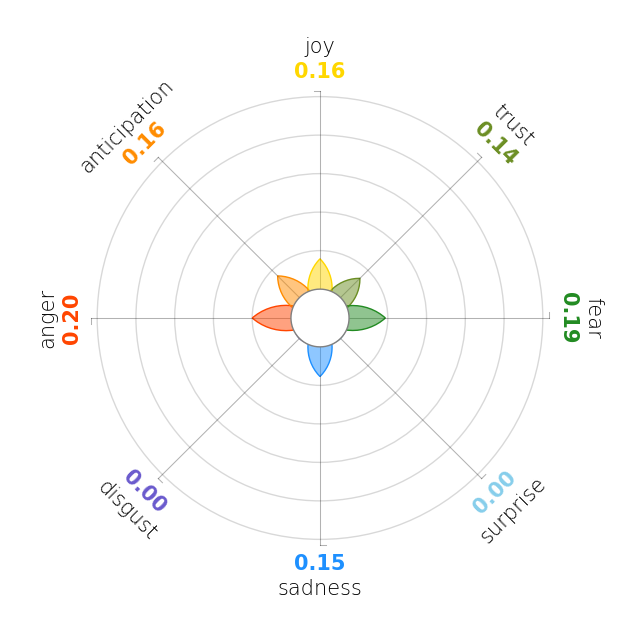

In [30]:
#plot wheel
from pyplutchik import plutchik
emotions={
    'joy':prob[1],
    'trust':prob[2],
    'fear':prob[5],
    'surprise':0,
    'sadness':prob[4],
    'disgust':0,
    'anger':prob[0],
    'anticipation':prob[3]
}
plutchik(emotions)

In [31]:
test_results = {}

test_results['model'] = model.evaluate(
    train_features, train_labels, verbose=0)

print(f" Accuracy: {test_results}")

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [32]:
model.predict(test_features)

1/1 [==============================] - 9s 9s/step


TFSequenceClassifierOutput(loss=None, logits=array([[-0.14047754,  0.3345204 ,  0.53231156, -0.64712846,  0.39203188,
         0.18751253],
       [-0.23937094,  0.32823318,  0.4432897 , -0.6843817 ,  0.42273876,
         0.2532632 ]], dtype=float32), hidden_states=None, attentions=None)